In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import scikitplot as skp

%matplotlib inline

sns.set_palette('pastel')

## Read the Data

In [2]:
# read the pickled data
pickle_data = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'clean_data.pickle'), 'rb')
data = pickle.load(pickle_data)
# rename the columns for plotting
data.columns = ['Year', 'Income Index', 'Education Index', 'Percent White',
                'Rent Index', 'Value Index', 'Percent Employed']
# first column is year, which I don't want to mess with
cols = data.columns[1:]

## Standardization

In [3]:
# create instance of RobustScaler class
rs = RobustScaler()
# fit and transform the data and put back into a dataframe
data_rs = pd.DataFrame(rs.fit_transform(data[cols]), index=data.index, columns=cols)

## Dimension Reduction (Plotting)

In [4]:
# create instance of PCA class
pca = PCA()
# fit and transform the data and put back into dataframe
data_pca = pd.DataFrame(pca.fit_transform(data_rs), index=data.index)
# rename the columns
data_pca.columns = ['pca{}'.format(i) for i in range(1, 7)]

## KMeans Clustering (6 clusters)

In [5]:
# create kmeans model
kmeans = KMeans(n_clusters=6)
# fit the model and predict the labels
labels = kmeans.fit_predict(data_rs)
# assign the clusters to a new column in the original dataset
data['clusters'] = labels
data.head()

,Year,Income Index,Education Index,Percent White,Rent Index,Value Index,Percent Employed,clusters
geoid,,,,,,,,
48021950100,2000,73599.981153,3.617289,86.192698,723.087018,153375.729370,98.308865,0
48021950200,2000,67668.904461,3.154098,67.591995,752.448335,118748.232408,96.715168,3
48021950300,2000,78678.935400,3.669384,81.097069,808.205215,178808.676101,97.032326,0
48021950400,2000,75438.539903,4.075207,76.605317,869.478211,158917.899778,98.340471,0
48021950600,2000,67172.153161,3.465056,88.921283,737.822784,134719.422878,96.891342,0


## Clustering Analysis

### Ordering the Clusters
I'll start by logically ordering the clusters by median home value from lowest to highest. The reason for this is that the numbering of kmeans cluster centers is random and changes from model run to model run. Ordering them logically will come in handy when seeing how the neighborhoods move between clusters.

In [6]:
# group by cluster -> get median home value for each cluster -> rank them (low to high)
# -> cast as integeger -> convert to dict -> map new cluster numbers
clust_map = data.groupby('clusters')['Value Index'].median().rank().astype('int').to_dict()
# map the new cluster labels
data['clusters'] = data['clusters'].map(clust_map)
data.head()

,Year,Income Index,Education Index,Percent White,Rent Index,Value Index,Percent Employed,clusters
geoid,,,,,,,,
48021950100,2000,73599.981153,3.617289,86.192698,723.087018,153375.729370,98.308865,3
48021950200,2000,67668.904461,3.154098,67.591995,752.448335,118748.232408,96.715168,1
48021950300,2000,78678.935400,3.669384,81.097069,808.205215,178808.676101,97.032326,3
48021950400,2000,75438.539903,4.075207,76.605317,869.478211,158917.899778,98.340471,3
48021950600,2000,67172.153161,3.465056,88.921283,737.822784,134719.422878,96.891342,3


## Analyzing the Clusters

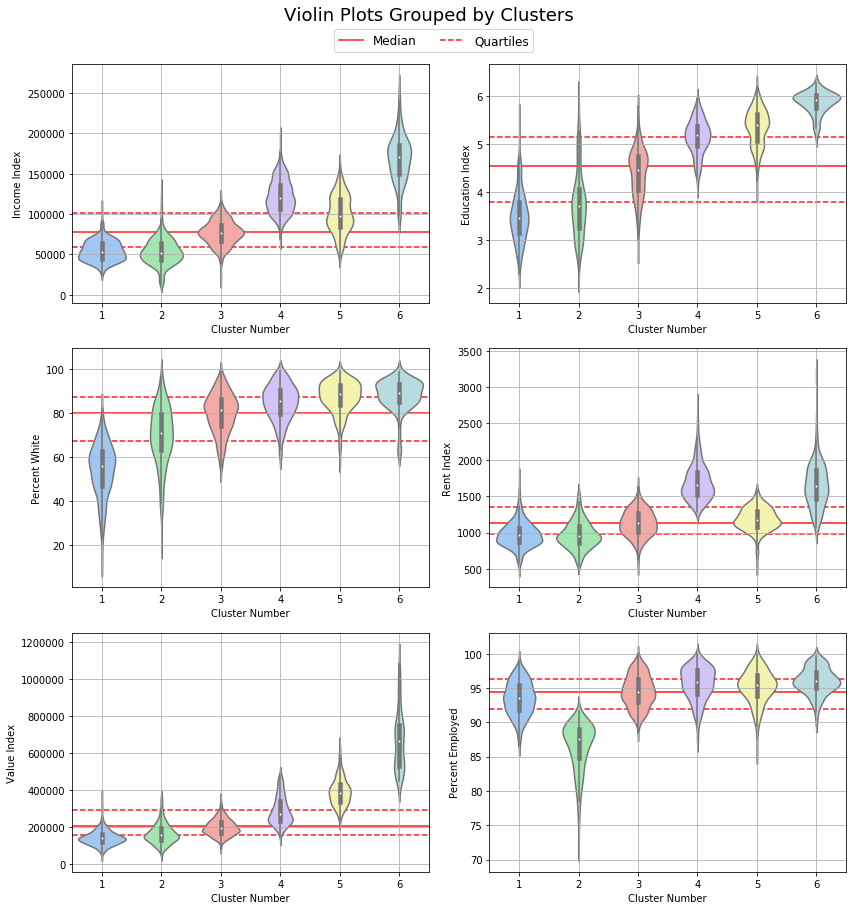

In [7]:
# create the figure and subplot axes
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
# loop through columns to make subplots
for col, ax in zip(cols, axes.flatten()):
    # plot the violins for each column
    _ = sns.violinplot(x='clusters', y=col, data=data, ax=ax)
    # create horizontal lines for median and 25th/75th quartiles
    _ = ax.axhline(data[col].median(), c='r', label='Median', alpha=0.9, zorder=0)
    _ = ax.axhline(data[col].quantile(0.25), c='r', linestyle='--', label='Quartiles', alpha=0.9, zorder=0)
    _ = ax.axhline(data[col].quantile(0.75), c='r', linestyle='--', alpha=0.9, zorder=0)
    # rename the xlabel
    _ = ax.set(xlabel='Cluster Number')
    # turn on the grid
    _ = ax.grid()

# create a super title for the figure
_ = fig.suptitle('Violin Plots Grouped by Clusters', y=1.05, fontsize=18)
_ = fig.tight_layout()
# create a single legend for the entire figure
_ = fig.legend(loc=(0.39, 0.942), ncol=2, fontsize=12)

## Analyzing Neighborhood Clustering

In [12]:
data.head()

,Year,Income Index,Education Index,Percent White,Rent Index,Value Index,Percent Employed,clusters
geoid,,,,,,,,
48021950100,2000,73599.981153,3.617289,86.192698,723.087018,153375.729370,98.308865,3
48021950200,2000,67668.904461,3.154098,67.591995,752.448335,118748.232408,96.715168,1
48021950300,2000,78678.935400,3.669384,81.097069,808.205215,178808.676101,97.032326,3
48021950400,2000,75438.539903,4.075207,76.605317,869.478211,158917.899778,98.340471,3
48021950600,2000,67172.153161,3.465056,88.921283,737.822784,134719.422878,96.891342,3


In [18]:
clusters_by_year = pd.pivot_table(data, columns='Year', values='clusters', index=data.index)

In [38]:
clusters_by_year.groupby(['2015', '2016'])['2016'].count().to_frame()

2016
2015 2016      
1    1       38
     2        2
     3       10
2    1        7
     2       15
     3       13
3    2        5
     3      123
     4        7
     5        7
4    4       40
     5        4
     6        1
5    3        1
     4        2
     5       48
6    5        1
     6       19

In [124]:
geoid_clusters = data.groupby('geoid')['clusters'].apply(list)
geoid_clusters = pd.DataFrame(data.groupby('geoid')['clusters'].apply(list), index=geoid_clusters.index)
geoid_clusters.head()

,clusters
geoid,
48021950100,"[3, 3, 3, 3, 3, 3, 3, 3, 3]"
48021950200,"[1, 1, 1, 1, 1, 2, 1, 1, 1]"
48021950300,"[3, 3, 3, 3, 3, 3, 2, 2, 3]"
48021950400,"[3, 3, 3, 3, 3, 2, 3, 3, 3]"
48021950501,"[3, 3, 1, 1, 1, 2, 2, 2, 2]"


In [ ]:
df

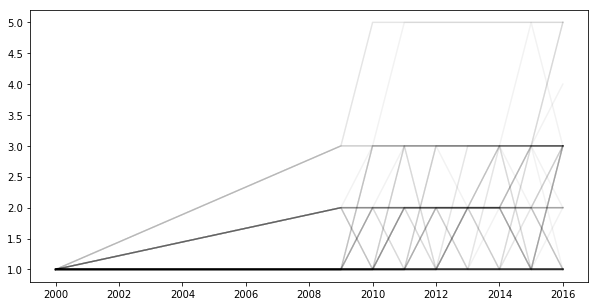

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for ix in geoid_clusters.index:
    if geoid_clusters.loc[ix][0] == 1:
        ax.plot([2000, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], geoid_clusters.loc[ix], c='k', alpha=0.05)